# Central Difference Method

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Initial Parameters

In [ ]:
#Stiffness of the building (Change to calculated value)
k = 90 *1000000           #N/m

#Mass of the building (Change to calculated value)
m = 489.60 * 1000         #kg

#Damping Ratio (Assuming 5% damping, change to desired value)
dr = 0.05 

#Calculating the natural frequency, Wn, the natural period, Tn, and the damping coefficient, c
Wn = np.sqrt(k / m)       #rad/s 
Tn = 2 * np.pi / Wn       #s 
c = 2 * m * dr * Wn       #N.sec/m

print(f'Stifness, k = {k:.2e} N/m\n'
      f'mass, m = {m:.2e} kg\n'
      f'Damping Ratio, r = {dr:.3f}\n'
      f'Natural Frequency, Wn = {Wn:.2f} rad/s\n'
      f'Natural Period, Tn = {Tn:.3f} s\n'
      f'Damping Coefficient, c = {c:.2f} N.s/m')

Stifness, k = 9.00e+07 N/m
mass, m = 4.90e+05 kg
Damping Ratio, r = 0.050
Natural Frequency, Wn = 13.56 rad/s
Natural Period, Tn = 0.463 s
Damping Coefficient, c = 663807.20 N.s/m


## Loading El Centro Dataset

In [19]:
elcentro_df = pd.read_csv('Data_Elcentro.csv')       #Replace with your file path
elcentro_df.head()

,time,acceleration
0,0.00,0.00630
1,0.02,0.00364
2,0.04,0.00099
3,0.06,0.00428
4,0.08,0.00758


## Initial Calculations

In [ ]:
#At i = 0, 
g = 9.81                                   #m/s^2

#Extracting Ground Acceleration Factor 
ground_acc_factors_g = elcentro_df['acceleration'].values / 100        #converts values from cm/s^2 to m/s^2
print(f'Initial Ground Acceleration Factor,g = {ground_acc_factors_g[0]} m/s^2')            

u_0 = 0           #Initial Displacement, m
v_0 = 0           #Initial Velocity, m/s

#Calculating Initial Force
P_values = -ground_acc_factors_g * m * g
P_0 = P_values[0]                               #N
print(f'Initial Load, P_0 = {P_0} N') 

#Calculating the Initial Acceleration
a_0 = (P_0 - (c*v_0) - (k * u_0)) /m            
print(f'Initial Displacement, u_0 = {u_0:.4f} m\n'
      f'Initial Velocity, v_0 = {v_0:.4f} m/s\n'
      f'Initial Acceleration = {a_0} m/s^2')

#Calculating u-1
delta_t = ground_acc_factors_g[1] - ground_acc_factors_g[0]  #s
u_minus_1 = u_0 - (v_0 * delta_t) + ((a_0 * delta_t**2)/2)
print(f'u-1 = {u_minus_1:.11f} m')

#Calculating k hat
k_hat = (m / delta_t**2) + (c / (2 * delta_t ))
print(f'k_hat = {k_hat:.4g} kg/s^2')

#Calculating a
a = (m / delta_t**2) - (c / (2 * delta_t))
print(f'a = {a:.4g}')

#Calculating b
b = k - (2 * m / delta_t**2)
print(f'b = {b:.4g}')
  
p_hat_0 = P_0 - (a * u_minus_1) - (b * u_0)
print(f'p_hat_0 = {p_hat_0:.4f} N')

#Calculating u_1
u_1 = p_hat_0 / k_hat
print(f'u_1 = {u_1:.15f} m')

Initial Ground Acceleration Factor,g = 6.3e-05 m/s^2
Initial Load, P_0 = -302.587488 N
Initial Displacement, u_0 = 0.0000 m
Initial Velocity, v_0 = 0.0000 m/s
Initial Acceleration = -0.00061803 m/s^2
u-1 = -0.00000000000 m
k_hat = 6.919e+14 kg/s^2
a = 6.92e+14
b = -1.384e+15
p_hat_0 = -151.2910 N
u_1 = -0.000000000000219 m


## Initializing Dataframe

In [5]:
values = ['t_i', 'P_i', 'u_i_minus_1', 'u_i', 'P^i', 'u_i_plus_1']
data = pd.DataFrame(columns = values)

## Storing Values from Initial Calculations in DataFrame

In [11]:
data['t_i'] = elcentro_df['time'].values
data['P_i'] = P_values
data['u_i_minus_1'] = np.nan
data['u_i'] = np.nan
data['P^i'] = np.nan
data['u_i_plus_1'] = np.nan

data.loc[0, 'P_i'] = P_0
data.loc[0, 'u_i_minus_1'] = u_minus_1
data.loc[0, 'u_i'] = u_0
data.loc[0, 'P^i'] = p_hat_0
data.loc[0, 'u_i_plus_1'] = u_1

In [12]:
data.head()

,t_i,P_i,u_i_minus_1,u_i,P^i,u_i_plus_1
0,0.00,-302.587488,-2.186467e-13,0.0,-151.291016,-2.186467e-13
1,0.02,-174.828326,NaN,NaN,NaN,NaN
2,0.04,-47.549462,NaN,NaN,NaN,NaN
3,0.06,-205.567373,NaN,NaN,NaN,NaN
4,0.08,-364.065581,NaN,NaN,NaN,NaN


## Central Difference Method Loop

In [13]:
for i in range(1, len(data)):           #Iteration starts from i = 1

    #Copying values of u_i_minus_1 amd u_i from previous iteration
    data.loc[i, 'u_i_minus_1'] = data.loc[i-1, 'u_i']
    data.loc[i, 'u_i'] = data.loc[i-1, 'u_i_plus_1']

    #Calculating P^i
    data.loc[i, 'P^i'] = data.loc[i, 'P_i'] - ((a * data.loc[i, 'u_i_minus_1']) + (b * data.loc[i, 'u_i']))

    #Calculating u_i_plus_1
    data.loc[i, 'u_i_plus_1'] = data.loc[i, 'P^i'] / k_hat

In [20]:
data

,t_i,P_i,u_i_minus_1,u_i,P^i,u_i_plus_1
0,0.00,-302.587488,-2.186467e-13,0.000000e+00,-151.291016,-2.186467e-13
1,0.02,-174.828326,0.000000e+00,-2.186467e-13,-477.415795,-6.899641e-13
2,0.04,-47.549462,-2.186467e-13,-6.899641e-13,-851.101736,-1.230017e-12
3,0.06,-205.567373,-6.899641e-13,-1.230017e-12,-1430.368416,-2.067177e-12
4,0.08,-364.065581,-1.230017e-12,-2.067177e-12,-2373.721382,-3.430516e-12
...,...,...,...,...,...,...
1555,31.10,9.125654,3.146824e-10,3.144222e-10,217391.242808,3.141751e-10
1556,31.12,6.243869,3.144222e-10,3.141751e-10,217226.469862,3.139370e-10
1557,31.14,2.881786,3.141751e-10,3.139370e-10,217064.544505,3.137029e-10
1558,31.16,-0.000000,3.139370e-10,3.137029e-10,216902.585075,3.134689e-10


## Data Plots

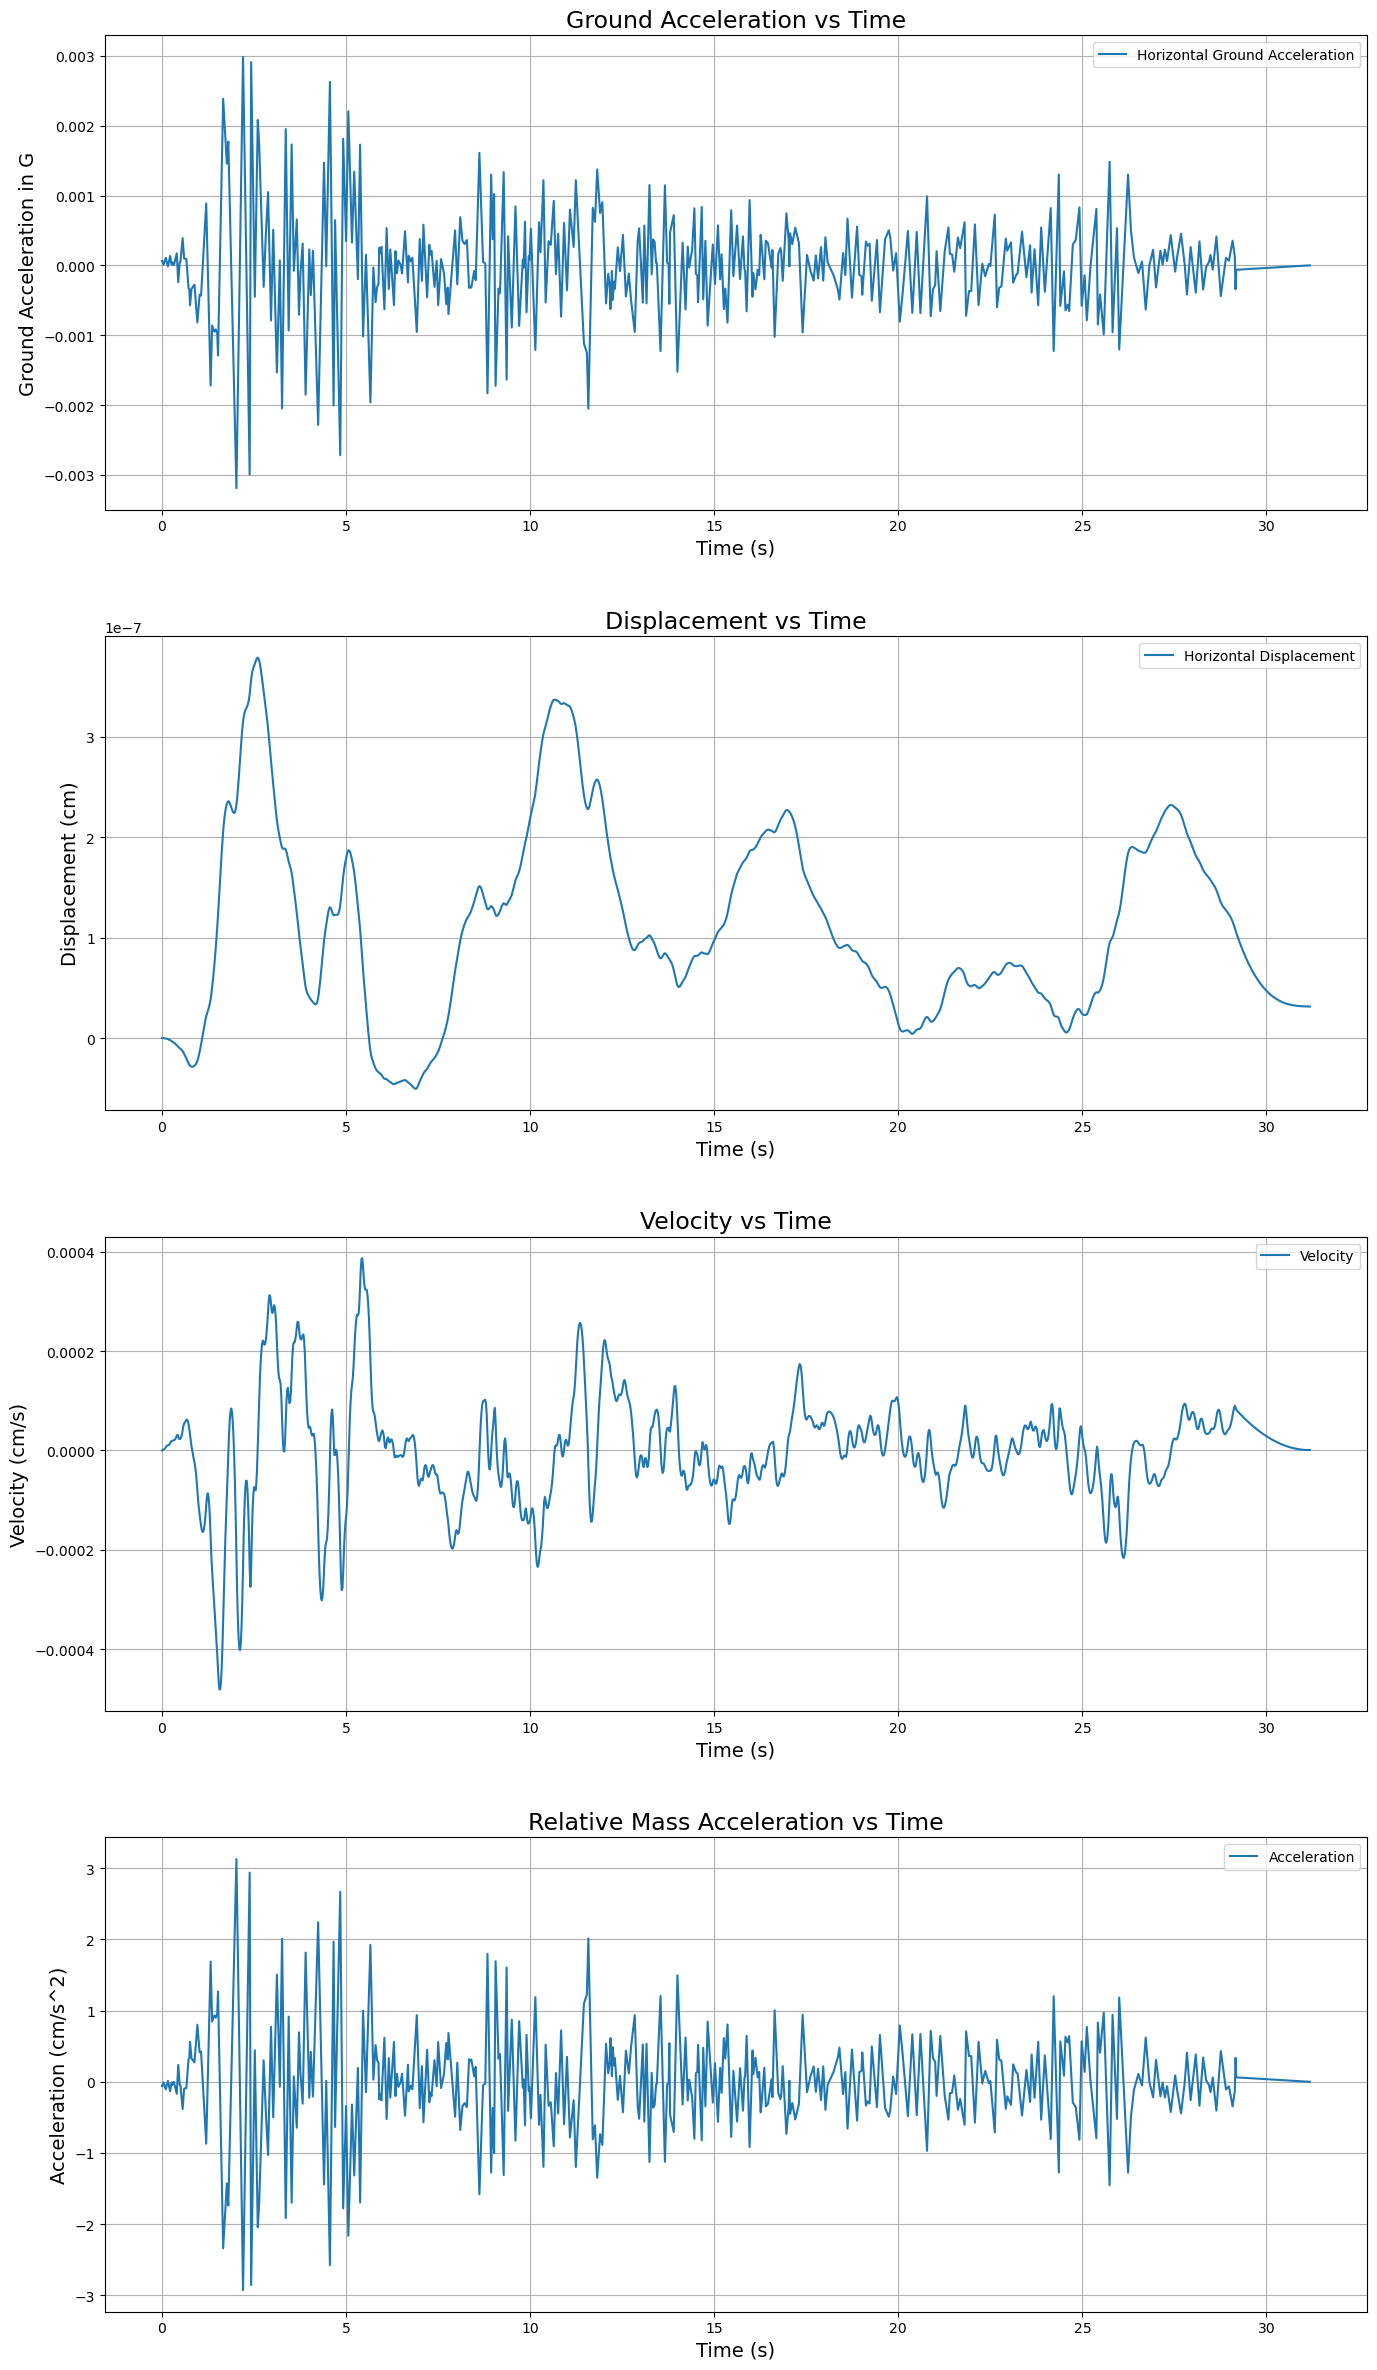

In [ ]:
displacement = data['u_i'].values * 100  #Converting to cm
time = data['t_i'].values

#Calculating the velocity for each time step
velocity = ((data['u_i_plus_1'] - data['u_i_minus_1']) / (2 * delta_t)) * 100  #Converting to cm/s

#Calculating the acceleration for each time step
acceleration = ((data['u_i_plus_1'] - 2 * data['u_i'] + data['u_i_minus_1']) / (delta_t**2)) * 100 #Converting to cm/s^2

fig, ax = plt.subplots(4, 1, figsize = (15, 25))
fig.tight_layout(pad = 7.0)

#Plot of Ground Acceleration against Time
ax[0].plot(time, ground_acc_factors_g, label = 'Horizontal Ground Acceleration')
ax[0].set_xlabel('Time (s)', fontsize = 14)
ax[0].set_ylabel('Ground Acceleration in G', fontsize = 14)
ax[0].set_title('Ground Acceleration vs Time', fontsize = 17)
ax[0].grid(True)
ax[0].legend()

#Plot of Displacement against Time
ax[1].plot(time, displacement, label = 'Horizontal Displacement')
ax[1].set_xlabel('Time (s)', fontsize = 14)
ax[1].set_ylabel('Displacement (cm)', fontsize = 14)
ax[1].set_title('Displacement vs Time', fontsize = 17)
ax[1].grid(True)
ax[1].legend()

#Plot of Velocity against Time
ax[2].plot(time, velocity, label = 'Velocity')
ax[2].set_xlabel('Time (s)', fontsize = 14)
ax[2].set_ylabel('Velocity (cm/s)', fontsize = 14)
ax[2].set_title('Velocity vs Time', fontsize = 17)
ax[2].grid(True)
ax[2].legend()

#Plot of Acceleration against Time
ax[3].plot(time, acceleration, label = 'Acceleration')
ax[3].set_xlabel('Time (s)', fontsize = 14)
ax[3].set_ylabel('Acceleration (cm/s^2)', fontsize = 14)
ax[3].set_title('Relative Mass Acceleration vs Time', fontsize = 17)
ax[3].grid(True)
ax[3].legend()

plt.show()